In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import matplotlib.pyplot as plt
from src.config import get_dataset_and_user
%matplotlib inline

In [2]:
# get data
X_iris, user_iris = get_dataset_and_user('iris')
y_iris = user_iris.get_label(X_iris, update_counter=False)

X_housing, user_housing = get_dataset_and_user('housing')
y_housing = user_housing.get_label(X_housing, update_counter=False)

In [3]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import f1_score
clf = SVC(C=1000, kernel='rbf')
clf.fit(X_iris,y_iris)
f1_score(clf.predict(X_iris), y_iris)

1.0

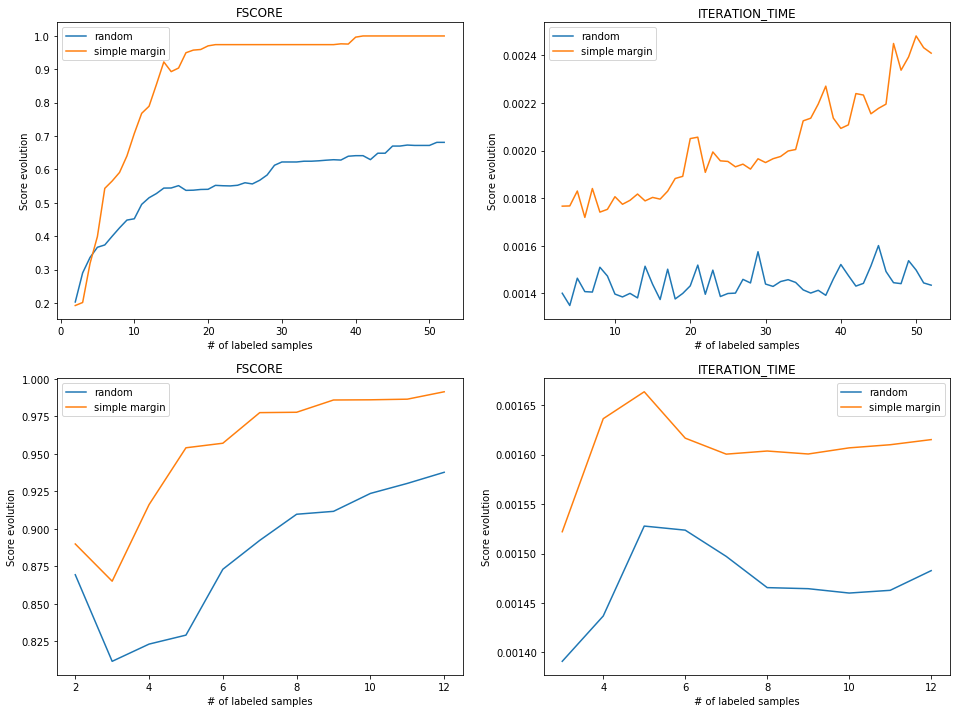

In [4]:
from src.active_learning.svm import SimpleMargin, SolverMethod, OptimalMargin
from src.active_learning.linear import LinearMajorityVote
from src.active_learning.agnostic import RandomLearner
from src.initial_sampling import FixedSizeStratifiedSampler
from src.showdown import Showdown
from src.plotting import plot_showdown

user_housing.max_iter = 50
user_iris.max_iter = 10

active_learners_list = [
    ("random", RandomLearner(SVC(C=100, kernel='rbf'))),
    #("optimal linear", OptimalMargin(C=100, kind='kernel', kernel='rbf', chain_length=50, sample_size=8, threshold=0.9, factorization_type='diagonalize')),
    ("simple margin", SimpleMargin(kind='kernel', kernel='rbf', C=100)),
    #('cholesky CL=50', OptimalMargin(C=100, kind='kernel', kernel='rbf', chain_length=50, factorization_type='cholesky')),
    #('diag th=0.9 CL=50', OptimalMargin(C=100, kind='kernel', kernel='rbf', chain_length=50, threshold=0.9, factorization_type='diagonalize')),
    #('diag th=0.9 CL=50 SS=8', OptimalMargin(C=100, kind='kernel', kernel='rbf', chain_length=50, sample_size=8, threshold=0.9, factorization_type='diagonalize')),
    #('diag th=0.9 CL=50, SS=16', OptimalMargin(C=100, kind='kernel', kernel='rbf', chain_length=50, sample_size=16, threshold=0.9, factorization_type='diagonalize')),
]

datasets_list = [
    ("housing", X_housing, user_housing),
    ("iris", X_iris, user_iris),
]

times = 20
showdown = Showdown()
output = showdown.run(datasets_list, active_learners_list, times)

#print(output.head())
plot_showdown(output, times, metrics_list=['fscore', 'iteration_time'])

## Next steps
    - add logging
    - label points prematurely based on whether they cut the current version space or not (cut estimate = # samples)
    - add offset (add column of 1's ?) -> works on above cases. Should test on sdss also.
    - change classifier to average of sampled w's (similar to majority vote in ALuMa)
    - add sdss queries
    - initial sampling: use sampling to pick k points which closely cut the VS in 1/2^k proportion / probability of each region close to uniform (entropy criteria?). Can we avoid enumerating all k subsets?
    - start using majoirity vote until 1 pos and 1 neg point have been found?
    
    
    - dozens of labeled samples, low selectivity
    - Problems: categorical attibutes, few positive samples, noise 
    - try queries from sdss paper (user rbf kernel) -> see if these algorithms work better than simple margin 

In [5]:
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
K = rbf_kernel(X_housing.values)
lamb, P = np.linalg.eigh(K + 1e-8 * np.eye(len(X_housing)))
L = P.dot(np.sqrt(np.diag(lamb)))

In [7]:
output['housing']['fscore'].swaplevel(0,1, axis=1).sort_index(level=0, axis=1)

max                    mean                     min                \
      random simple margin    random simple margin    random simple margin   
2   0.722222      0.838710  0.203014      0.192463  0.005988      0.043261   
3   0.800000      0.880000  0.290202      0.201478  0.018391      0.069401   
4   0.833333      0.833333  0.336411      0.318407  0.036364      0.090909   
5   0.846154      0.833333  0.366906      0.399106  0.030075      0.111111   
6   0.880000      0.880000  0.373899      0.543420  0.030075      0.117647   
7   0.880000      0.916667  0.399973      0.565448  0.086957      0.133333   
8   0.880000      0.833333  0.425163      0.591163  0.090909      0.142857   
9   0.880000      0.923077  0.448374      0.640489  0.090909      0.142857   
10  0.880000      0.916667  0.452297      0.707773  0.095238      0.142857   
11  0.880000      0.923077  0.495462      0.768193  0.095238      0.461538   
12  0.923077      0.962963  0.515279      0.789446  0.095238      0.276596   
13  0.923077      0.962963  0.527902      0.854728  0.105263      0.631579   
14  0.880000      0.962963  0.544238      0.922218  0.105263      0.857143   
15  0.880000      0.962963  0.544531      0.893148  0.105263      0.700000   
16  0.880000      0.962963  0.551585      0.903930  0.105263      0.700000   
17  0.880000      1.000000  0.537425      0.949715  0.105263      0.888889   
18  0.880000      1.000000  0.537952      0.957615  0.105263      0.923077   
19  0.880000      1.000000  0.540103      0.959461  0.105263      0.923077   
20  0.880000      1.000000  0.540579      0.970302  0.105263      0.923077   
21  0.880000      1.000000  0.552403      0.974000  0.105263      0.960000   
22  0.880000      1.000000  0.551291      0.974000  0.105263      0.960000   
23  0.880000      1.000000  0.550706      0.974000  0.105263      0.960000   
24  0.880000      1.000000  0.552680      0.974000  0.105263      0.960000   
25  0.880000      1.000000  0.560215      0.974000  0.105263      0.960000   
26  0.880000      1.000000  0.556712      0.974000  0.105263      0.960000   
27  0.880000      1.000000  0.567719      0.974000  0.105263      0.960000   
28  0.880000      1.000000  0.583413      0.974000  0.105263      0.960000   
29  0.880000      1.000000  0.612633      0.974000  0.125000      0.960000   
30  0.880000      1.000000  0.622458      0.974000  0.133333      0.960000   
31  0.880000      1.000000  0.622458      0.974000  0.133333      0.960000   
32  0.880000      1.000000  0.622458      0.974000  0.133333      0.960000   
33  0.880000      1.000000  0.624766      0.974000  0.133333      0.960000   
34  0.880000      1.000000  0.624766      0.974000  0.133333      0.960000   
35  0.880000      1.000000  0.625997      0.974000  0.133333      0.960000   
36  0.880000      1.000000  0.627796      0.974000  0.133333      0.960000   
37  0.880000      1.000000  0.629221      0.974000  0.133333      0.960000   
38  0.880000      1.000000  0.628221      0.976429  0.133333      0.928571   
39  0.880000      1.000000  0.639693      0.975714  0.133333      0.928571   
40  0.880000      1.000000  0.641360      0.996429  0.133333      0.928571   
41  0.880000      1.000000  0.641360      1.000000  0.133333      1.000000   
42  0.880000      1.000000  0.629455      1.000000  0.133333      1.000000   
43  0.880000      1.000000  0.648719      1.000000  0.133333      1.000000   
44  0.880000      1.000000  0.648719      1.000000  0.133333      1.000000   
45  0.880000      1.000000  0.670148      1.000000  0.133333      1.000000   
46  0.880000      1.000000  0.670148      1.000000  0.133333      1.000000   
47  0.880000      1.000000  0.673155      1.000000  0.133333      1.000000   
48  0.880000      1.000000  0.672035      1.000000  0.133333      1.000000   
49  0.880000      1.000000  0.672035      1.000000  0.133333      1.000000   
50  0.880000      1.000000  0.672035      1.000000  0.133333      1.000000   
51  0.880000      1.000000  0.6

In [11]:
type(X_iris.iloc[:,0])

pandas.core.series.Series

In [ ]:
import pandas as pd
x = pd.Series()